In [122]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import ssm
from sklearn import preprocessing
from sklearn.model_selection import KFold
from scipy import stats

from notebooks.imports import *
from config import dir_config, main_config
from src.utils import pmf_utils, glm_hmm_utils, plot_utils
import pickle


In [123]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

In [124]:
with open(Path(processed_dir, 'models_glm_hmm_session_wise.pkl'), 'rb') as f:
    session_wise_fits = pickle.load(f)

with open(Path(processed_dir, 'glm_hmm_data_session_wise.pkl'), 'rb') as f:
    data_session_wise = pickle.load(f)

with open(Path(processed_dir, 'unnormalized_data_session_wise.pkl'), 'rb') as f:
    unnormalized_data_session_wise = pickle.load(f)

session_metadata = pd.read_csv(Path(compiled_dir,'sessions_metadata.csv'))

### Best state

In [125]:
for n_state in range(session_wise_fits['test_ll'].shape[1]):
    print(f"Test likelihood for {n_state+2} states: {np.mean(session_wise_fits['test_ll'][:,n_state,:])}")
best_state = np.argmax(np.mean(session_wise_fits['test_ll'],axis=(0,2))) 
print(f"Best state is {best_state+2}")

Test likelihood for 2 states: -92.02188927822291
Test likelihood for 3 states: -92.32843124576326
Test likelihood for 4 states: -93.16443986029105
Test likelihood for 5 states: -93.79943943507169
Best state is 2


### Best fold for each session

In [126]:
best_fold_session_wise = []
for session in range(session_wise_fits['test_ll'].shape[0]):
    best_fold_session_wise.append(np.argmax(session_wise_fits["test_ll"][session,best_state,:]))

### model verification 


#### utils

In [152]:

def psychometric_fit(model, choices, scaled_input, unscaled_input, mask, ax, n_sample = 10):
    scaled_input = scaled_input[mask[:,0] == 1,:]
    unscaled_input = unscaled_input[mask[:,0] == 1,:]
    choices = choices[mask[:,0] == 1,:]
    data = {
        "signed_coherence": unscaled_input[:,0]*100,
        "choice": choices
    }
    x_data, y_data, _, x_model, y_model = pmf_utils.get_psychometric_data(data)
    
    x_model_hat, y_model_hat = np.full((n_sample,len(x_model)),np.nan), np.full((n_sample,len(y_model)),np.nan)
    for idx_sample in range(n_sample):
        _,choices_hat = model.sample(scaled_input.shape[0], input=scaled_input)
        data_fitted = {
            "signed_coherence": unscaled_input[:,0]*100,
            "choice": choices_hat
        }
        x_data, y_data_hat, _, x_model_hat[idx_sample,:], y_model_hat[idx_sample,:] = pmf_utils.get_psychometric_data(data_fitted)

    ax.plot(x_data,y_data,'ro')
    ax.plot(x_model,y_model,color='r',label='data')
    ax.plot(np.mean(x_model_hat, axis=0),np.mean(y_model_hat, axis=0),color = 'k',linestyle='--',label ='glm-hmm fits')
    ax.fill_between(np.mean(x_model_hat, axis=0), 
                    np.mean(y_model_hat, axis=0) - np.std(y_model_hat, axis=0), 
                    np.mean(y_model_hat, axis=0) + np.std(y_model_hat, axis=0),
                     color='k', alpha=0.3)

    ax.set_xlim(min(x_data),max(x_data))
    ax.set_xlabel('Coherence')
    ax.set_ylabel('choices toRF')
    ax.set_title('Psychometric fits',fontsize=15)
    ax.legend()
    # plt.show()

 

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # Import for custom grid layout

def plot_model_fits(model, choices, input, unscaled_input, mask, n_states, session_name, task_switch):
    transition_matrix = model.transitions.params
    transition_matrix = np.exp(transition_matrix)[0]
    weights = -model.observations.params
    posterior_probs = model.expected_states(data=choices, input=input)[0]

    fig = plt.figure(figsize=(14, 4))  # Wider figure for better spacing
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 2])  # Merge last two subplots

    cols = ['#ff7f00', '#4daf4a', '#377eb8']  # Add more colors if needed for higher n_states
    plt.suptitle(session_name)
    # ----  First Subplot: Psychometric Curves ----
    ax1 = plt.subplot(gs[0])
    psychometric_fit(model, choices, input, unscaled_input, mask, ax1)

    # ---- Second Subplot: GLM Weights ----
    ax2 = plt.subplot(gs[1])
    for k in range(n_states):
        ax2.plot(np.arange(input.shape[1]), weights[k][0], marker='o',
                 color=cols[k], linestyle='-', lw=1.5, label=f"State {k+1}")

    ax2.tick_params(axis='y', labelsize=10)
    ax2.set_ylabel("GLM weight", fontsize=15)
    ax2.set_xlabel("covariate", fontsize=15)
    ax2.set_xticks(range(input.shape[1]))
    ax2.set_xticklabels(['stimulus', 'bias', 'previous choice', 'previous target'], fontsize=12, rotation=15)
    ax2.axhline(y=0, color="k", alpha=0.5, ls="--")
    ax2.legend()
    ax2.set_title("GLM weights", fontsize=15)

    # ---- Third Subplot: Transition Matrix ----
    ax3 = plt.subplot(gs[2])
    im = ax3.imshow(transition_matrix, vmin=-0.8, vmax=1, cmap='bone')
    for i in range(transition_matrix.shape[0]):
        for j in range(transition_matrix.shape[1]):
            ax3.text(j, i, str(np.around(transition_matrix[i, j], decimals=2)), 
                     ha="center", va="center", color="k", fontsize=12)

    ax3.set_xlim(-0.5, n_states - 0.5)
    ax3.set_ylim(n_states - 0.5, -0.5)
    ax3.set_xticks(range(n_states))
    ax3.set_yticks(range(n_states))
    ax3.set_xlabel("state t+1", fontsize=15)
    ax3.set_ylabel("state t", fontsize=15)
    ax3.set_title("Generative transition matrix", fontsize=15)

    # ---- Fourth (Merged) Subplot: Posterior Probabilities ----
    ax4 = plt.subplot(gs[3])  # Merged across two columns
    for k in range(n_states):
        ax4.plot(posterior_probs[:, k], label=f"State {k + 1}", lw=2, color=cols[k])

    ax4.set_ylim(-0.01, 1.01)
    ax4.set_yticks([0, 0.5, 1])
    ax4.tick_params(axis='y', labelsize=10)
    ax4.set_xlabel("trial #", fontsize=15)
    ax4.set_ylabel("p(state)", fontsize=15)
    ax4.axvline(x=task_switch, color="k", alpha=0.5, ls="--")
    ax4.legend()
    ax4.set_title("Posterior Probabilities", fontsize=15)


    plt.tight_layout()
    plt.show()


#### GLM weights, transition matrix, p(state)

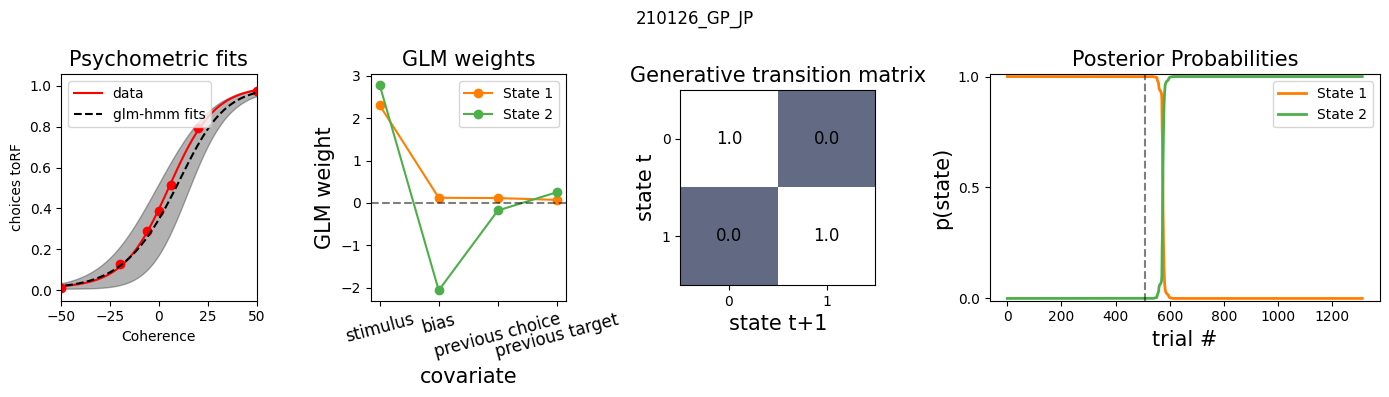

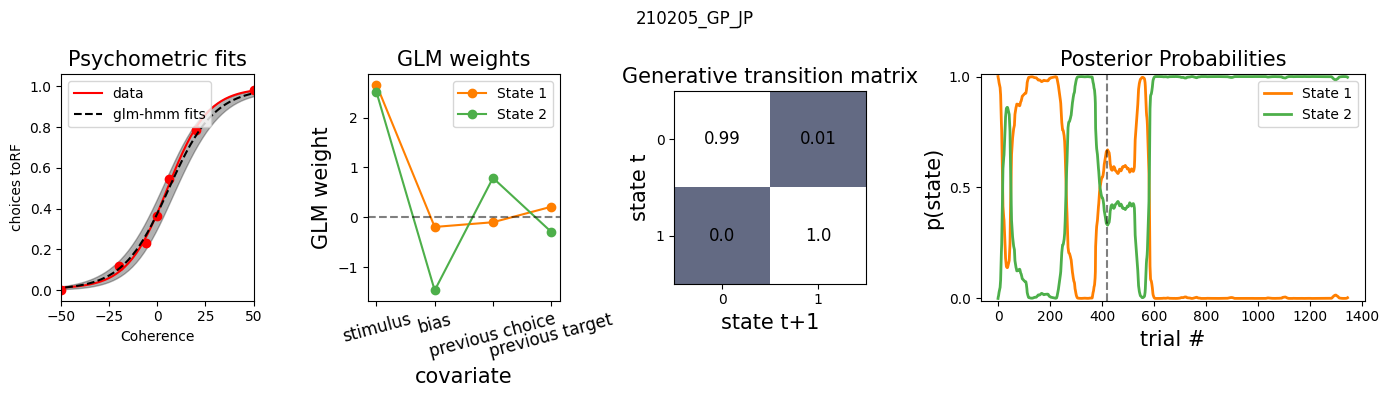

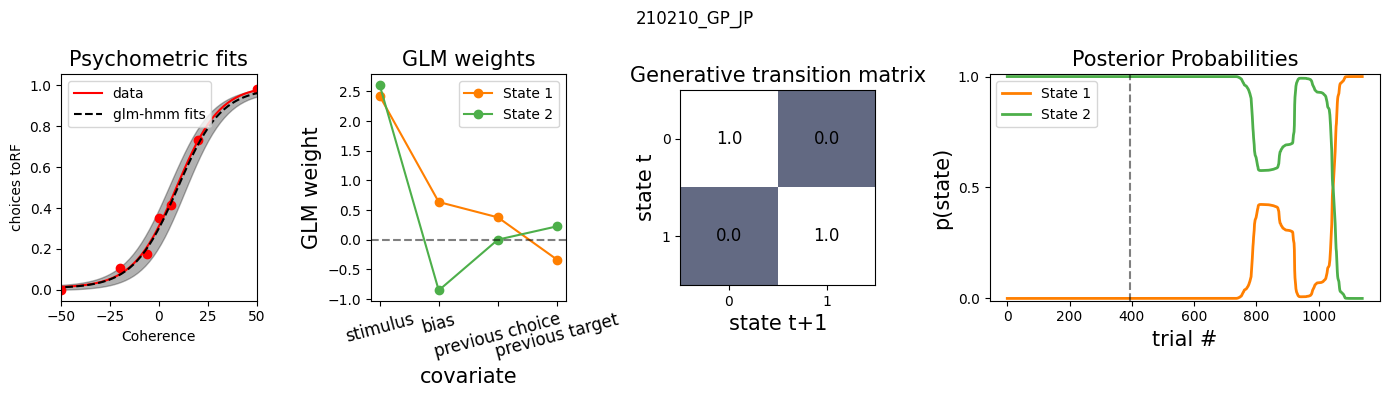

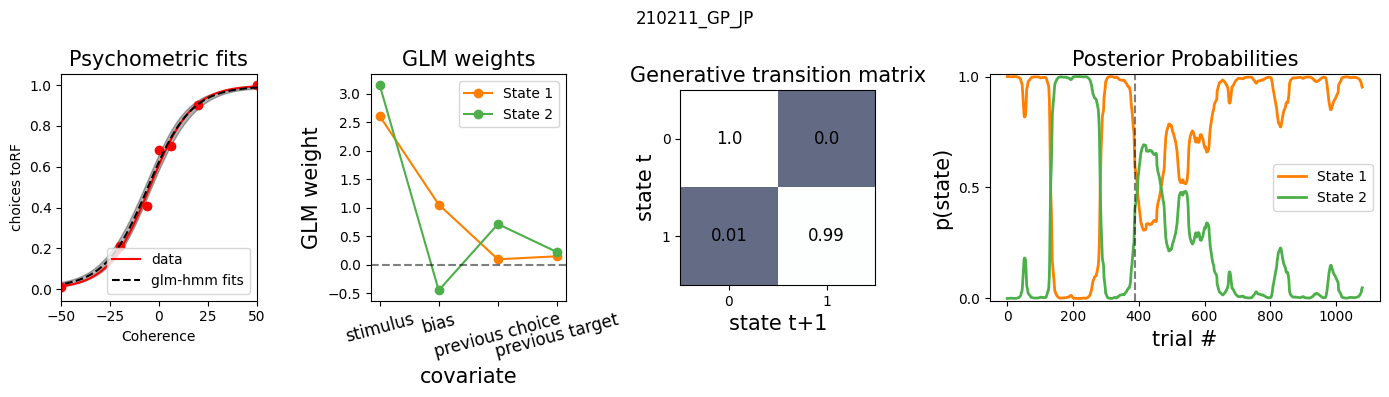

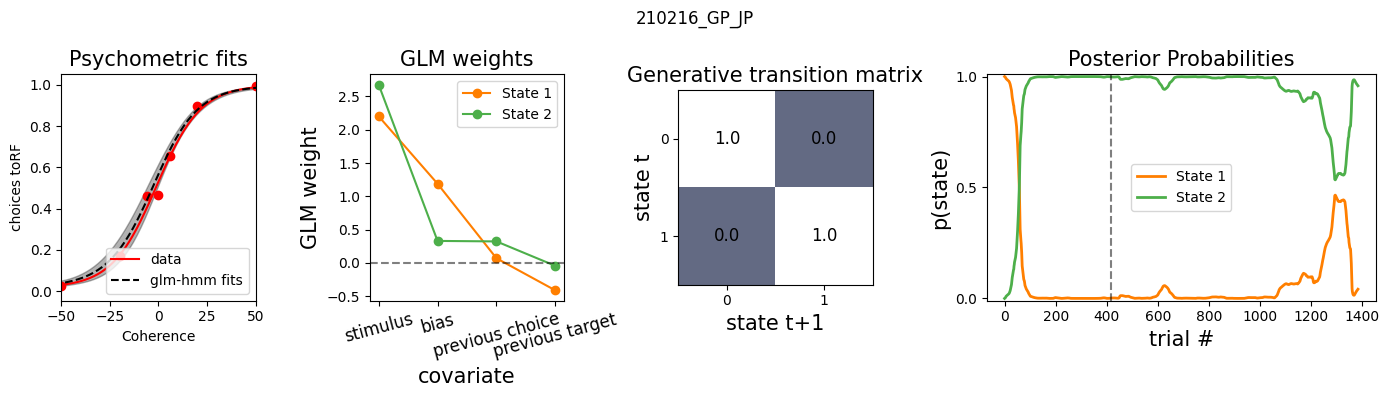

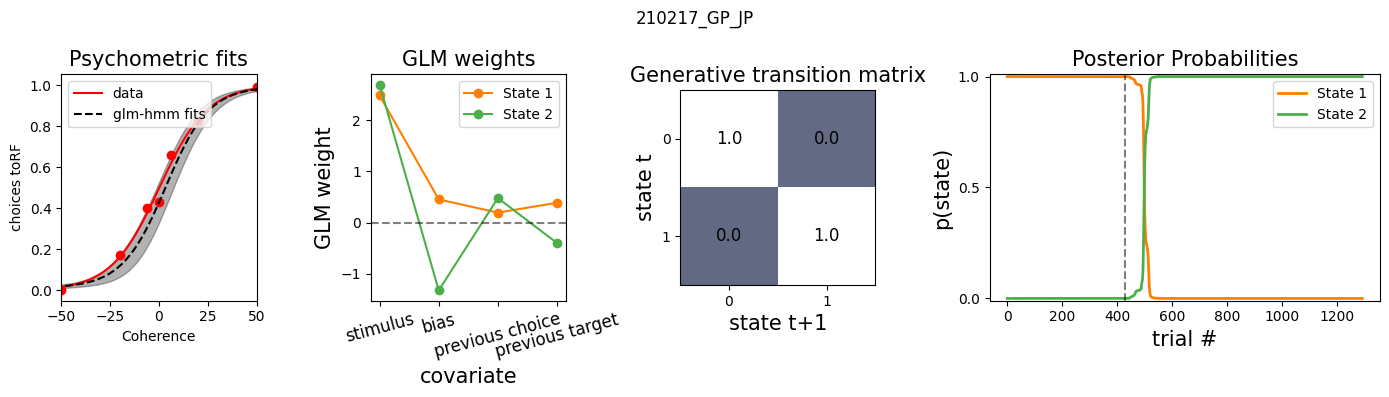

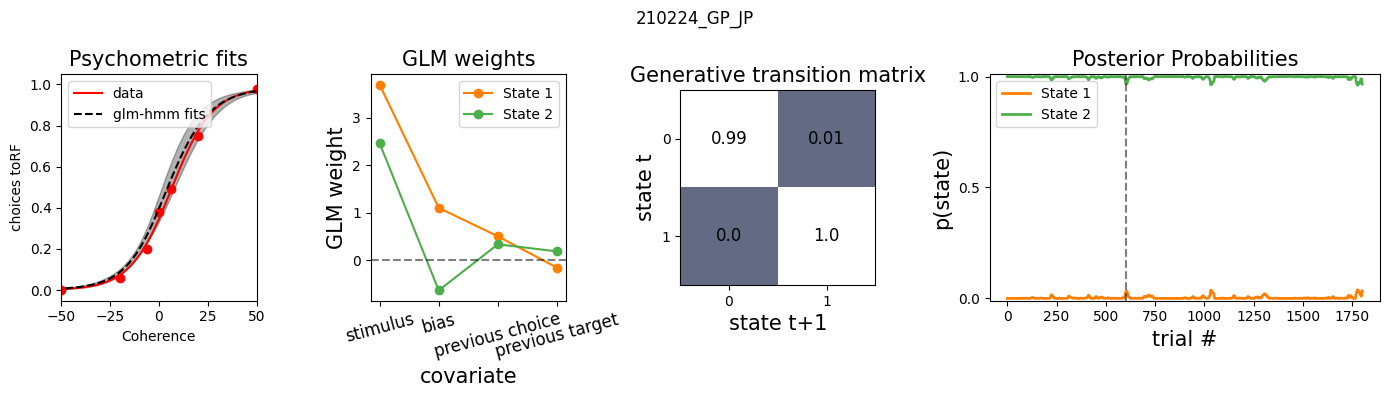

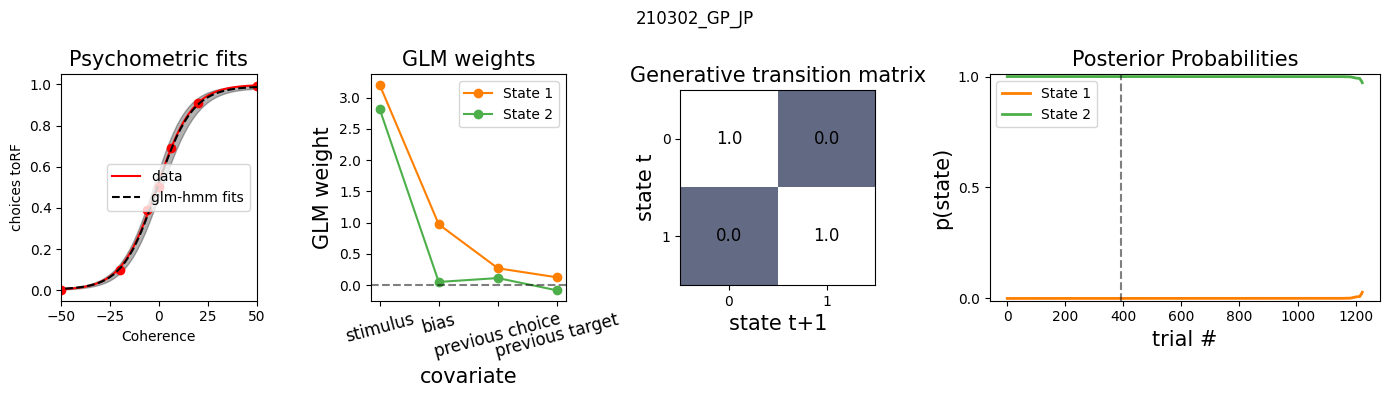

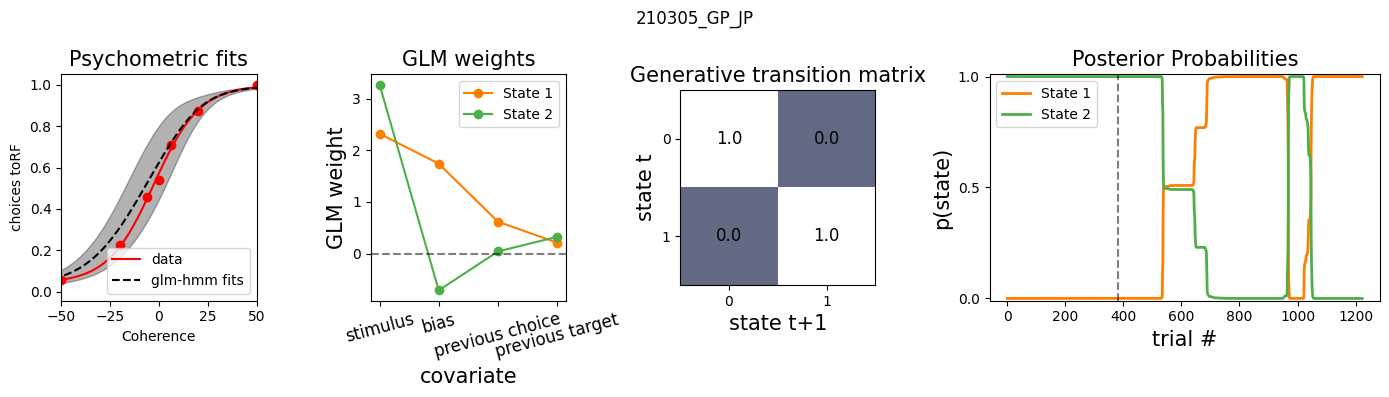

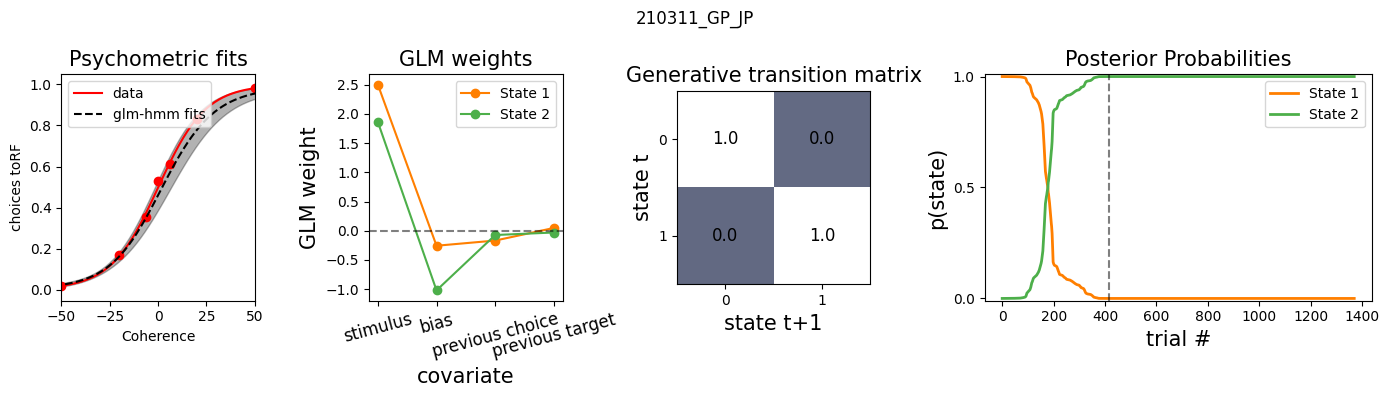

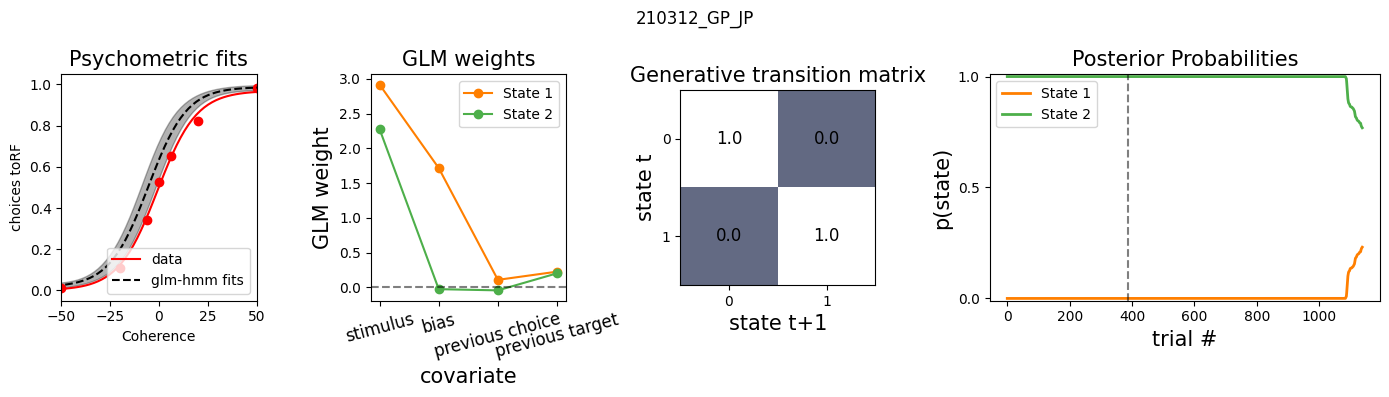

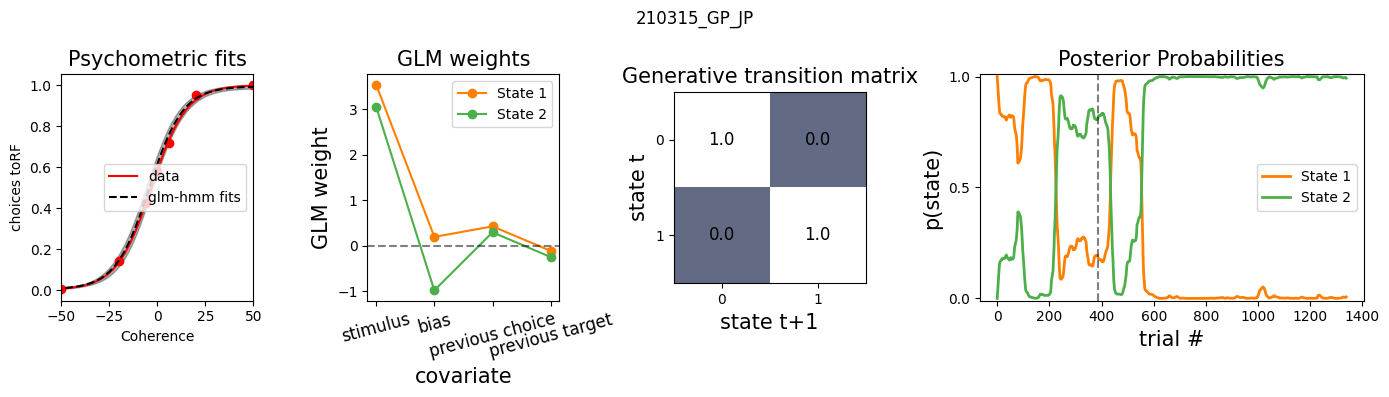

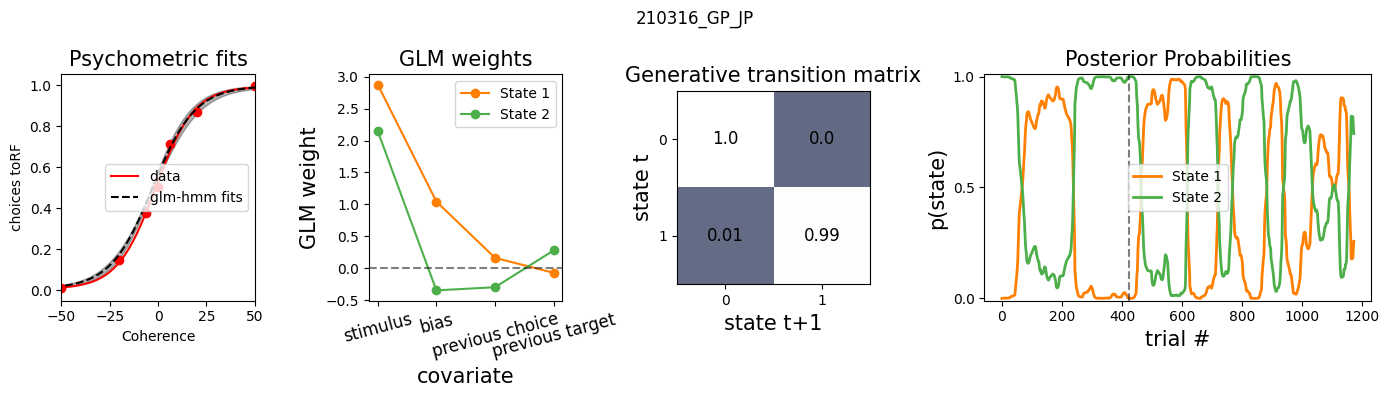

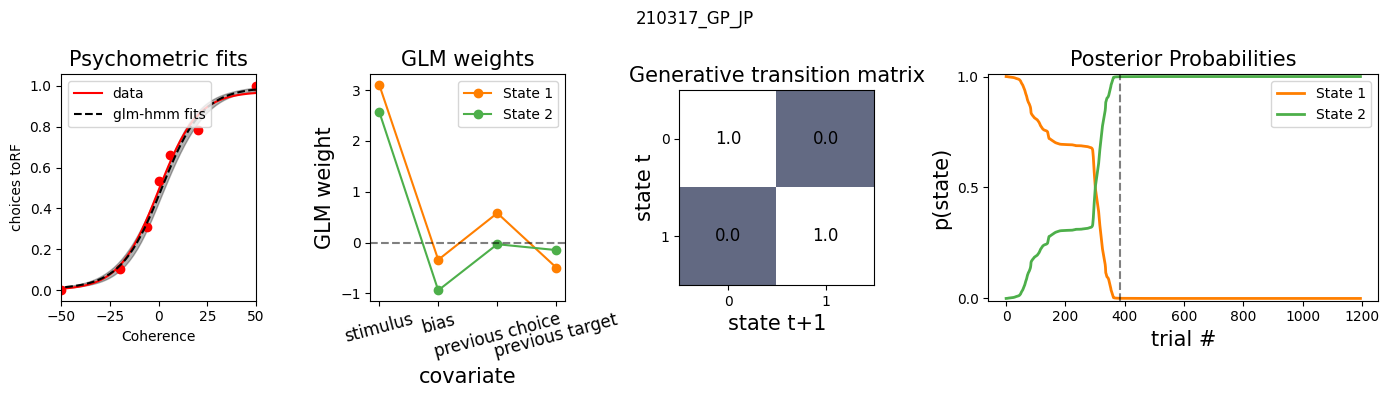

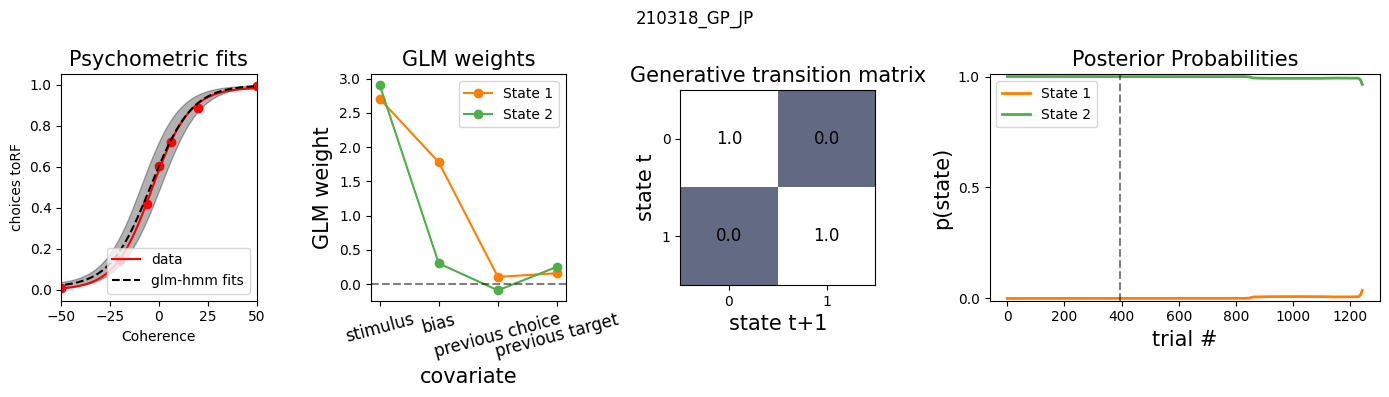

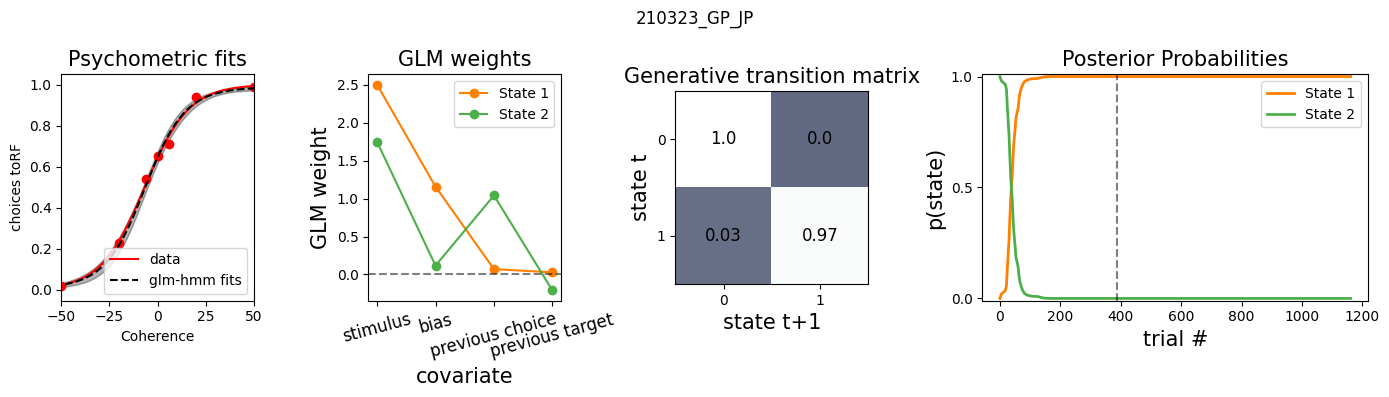

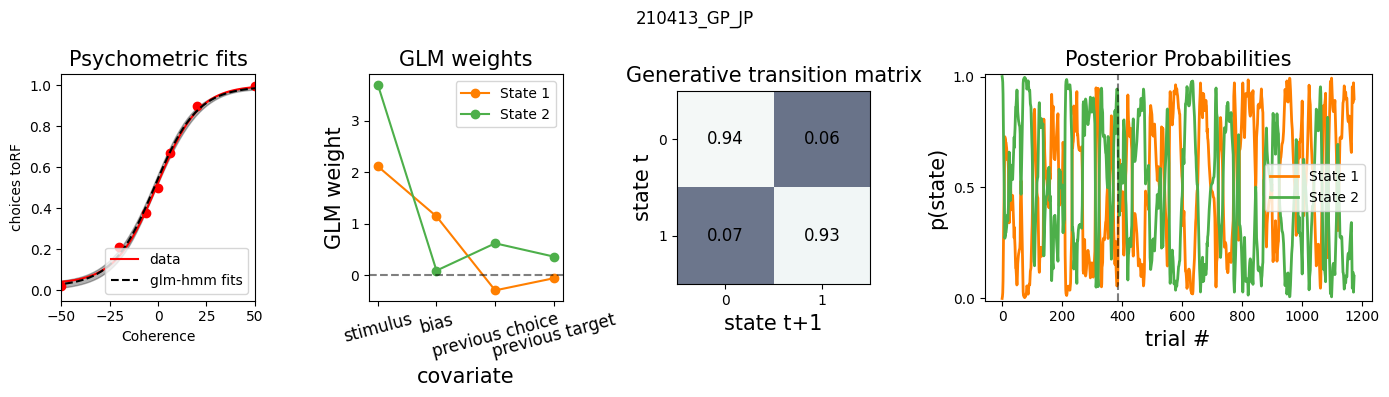

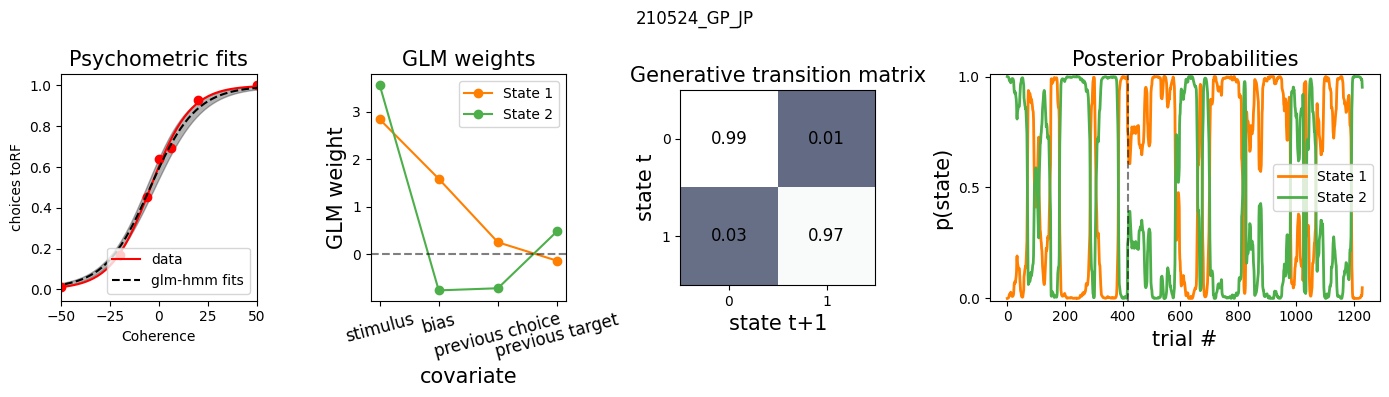

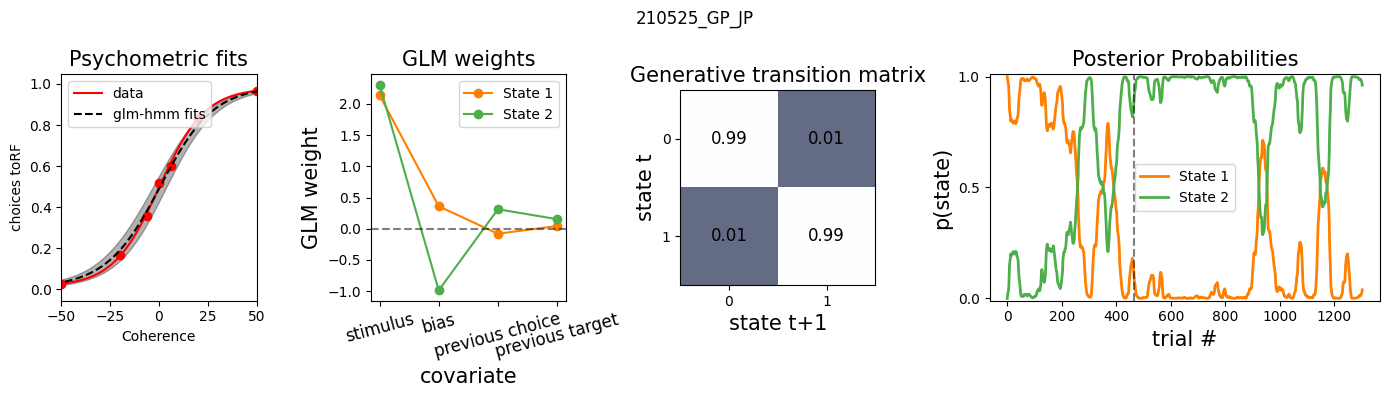

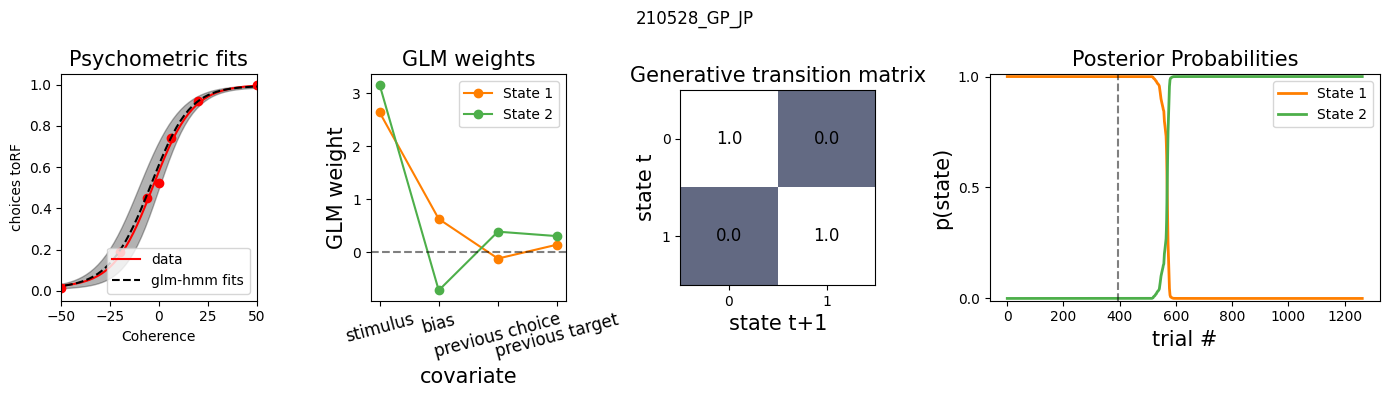

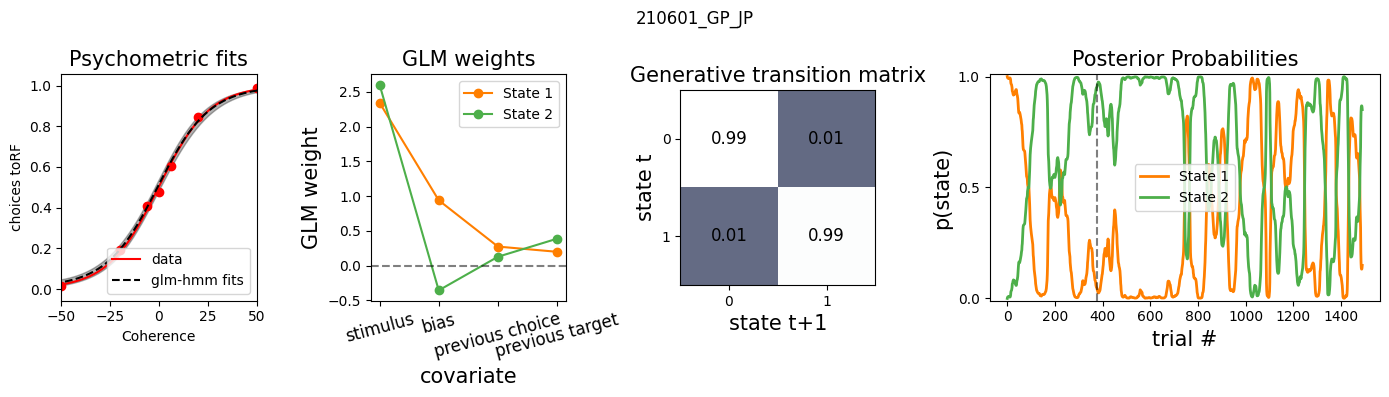

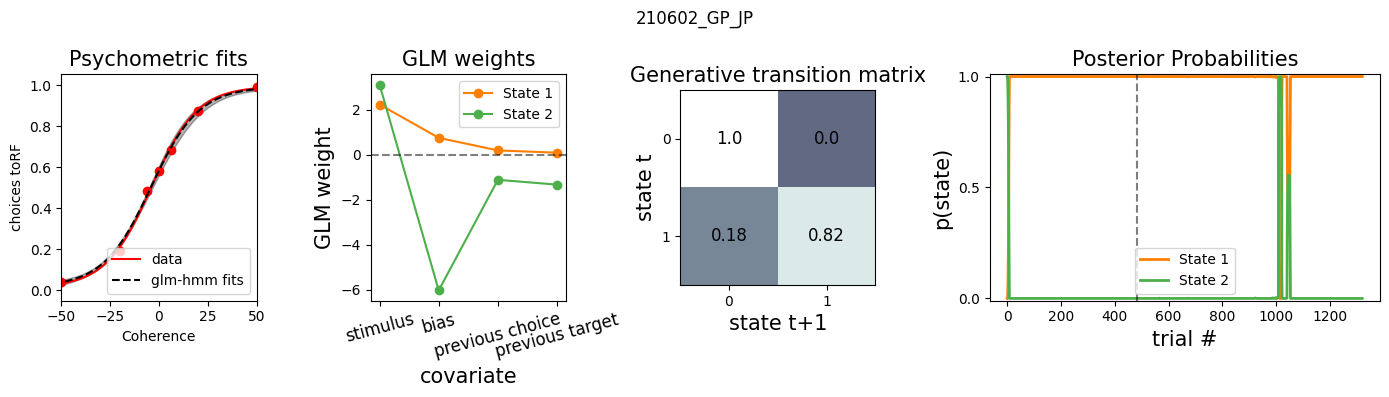

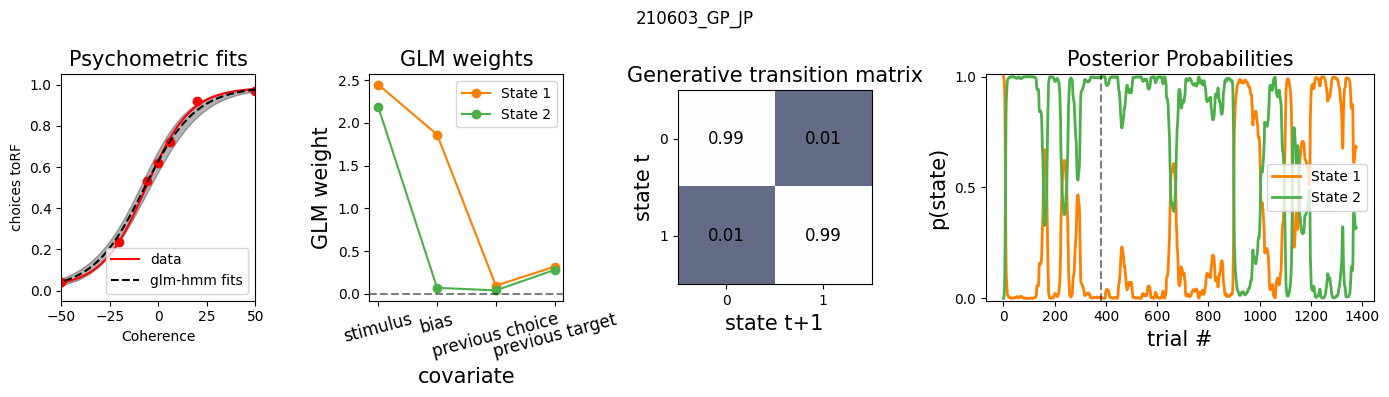

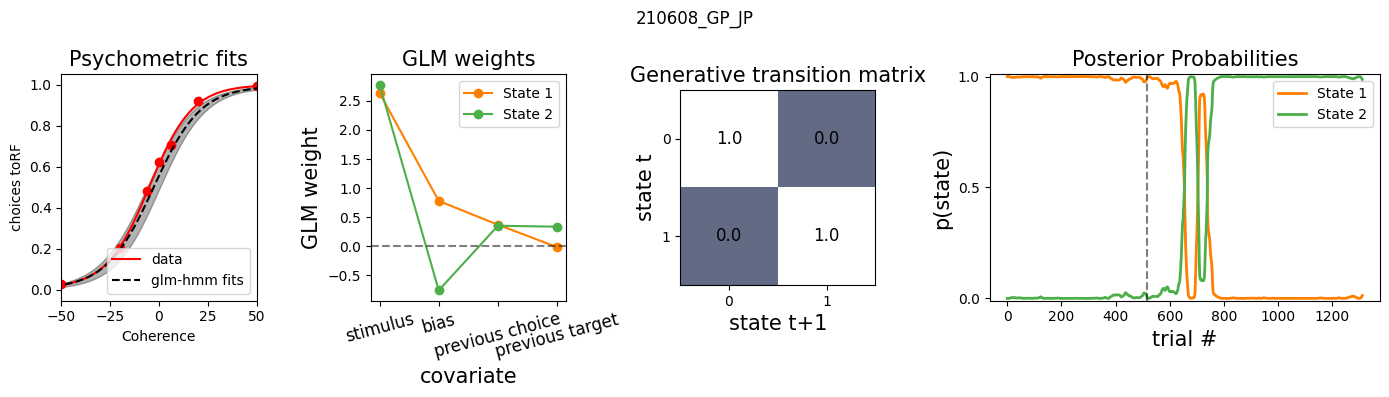

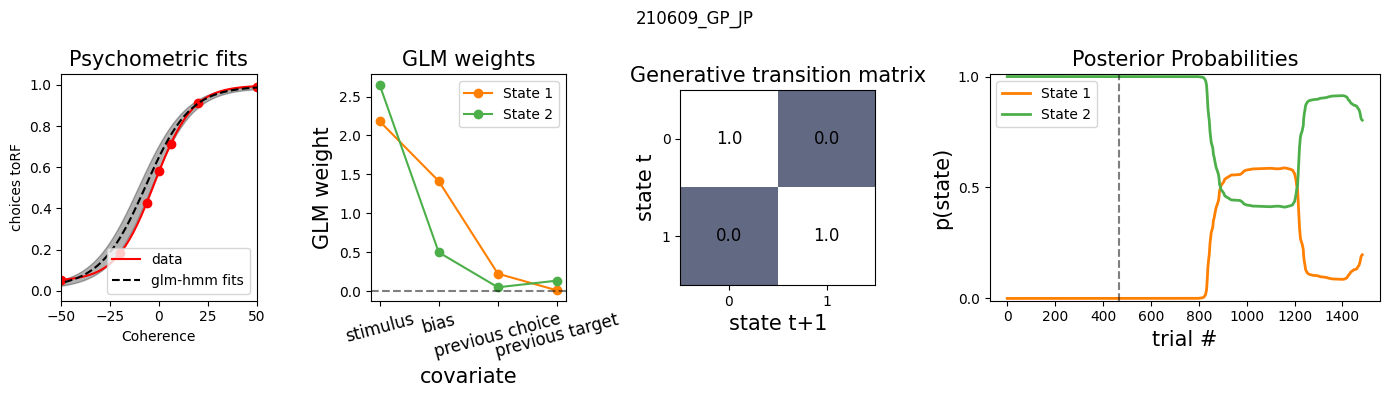

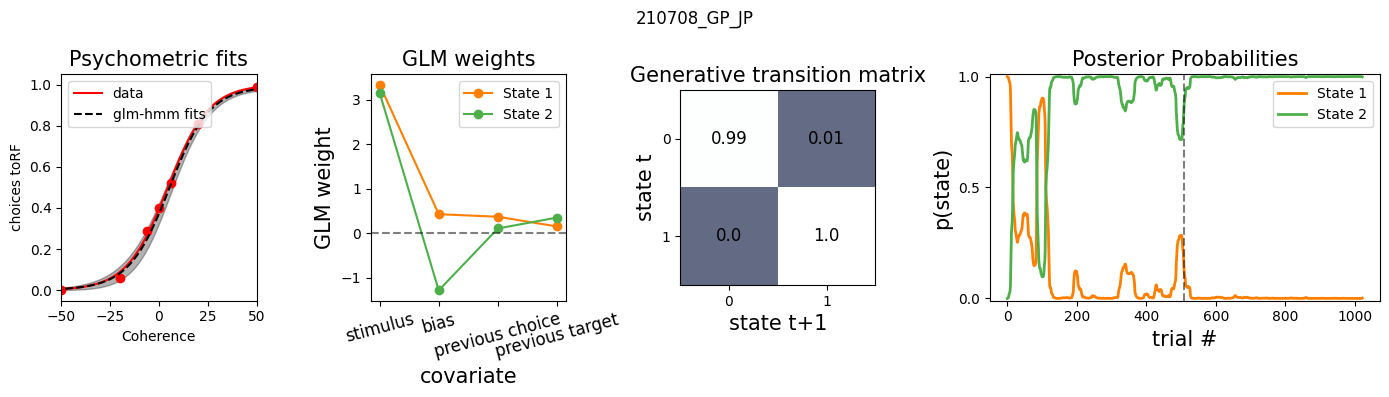

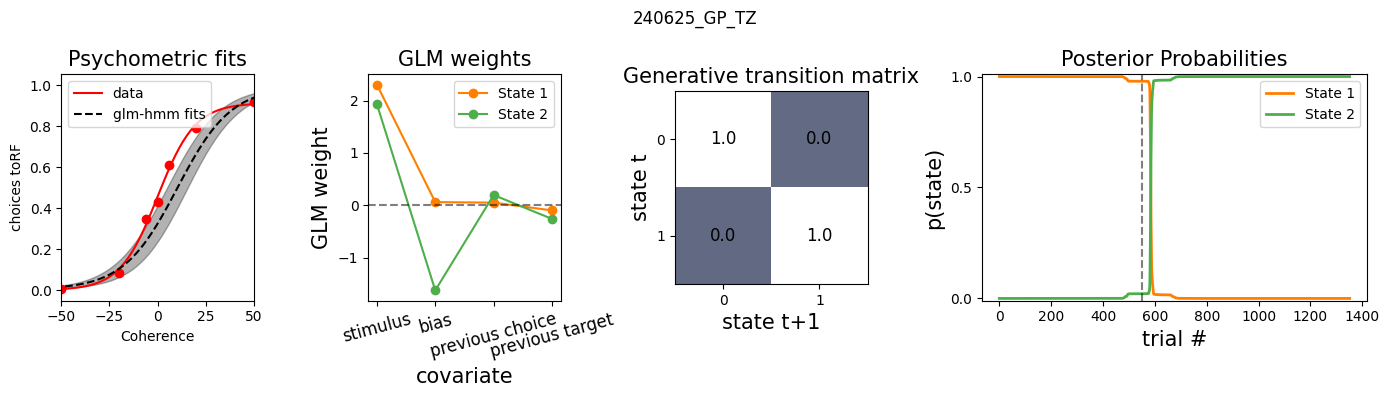

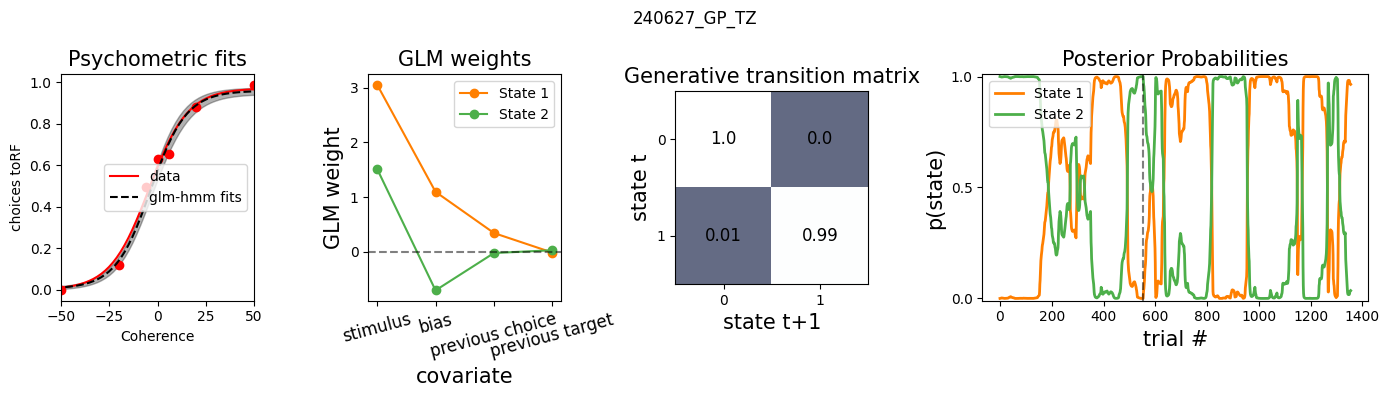

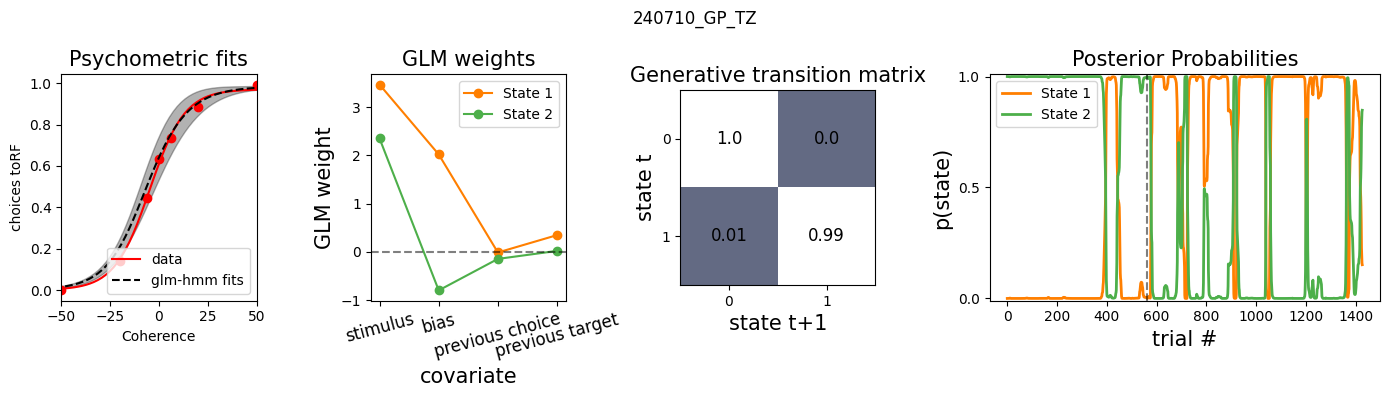

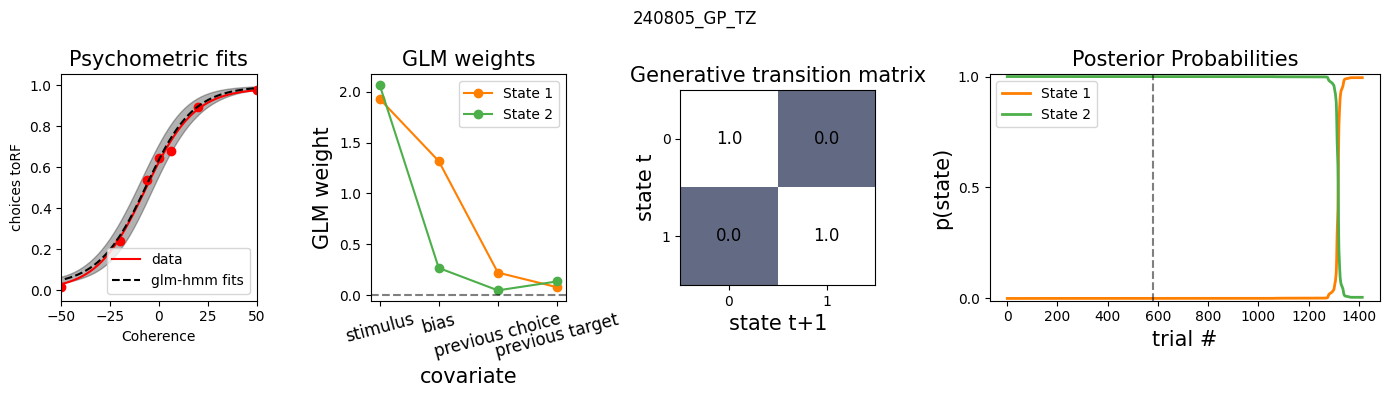

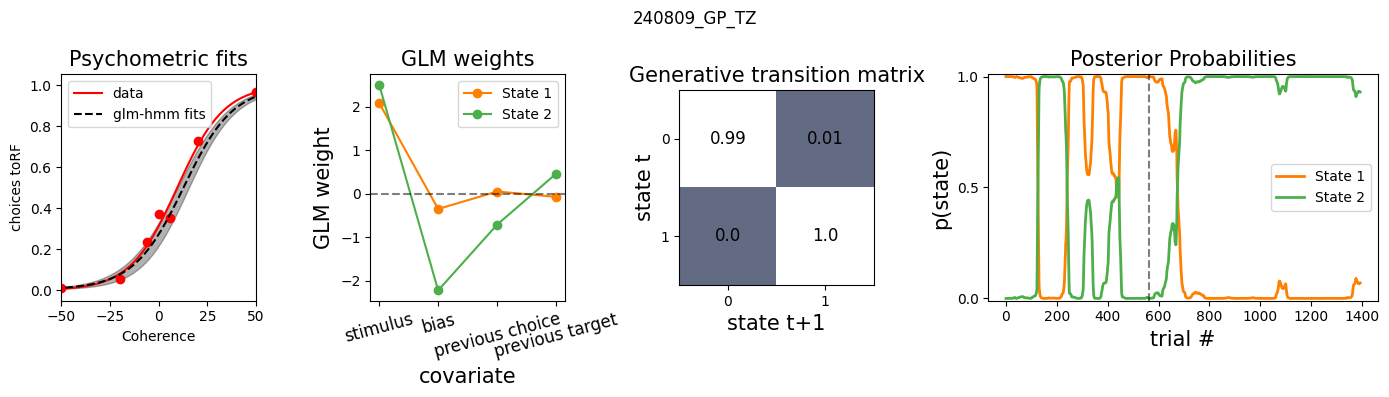

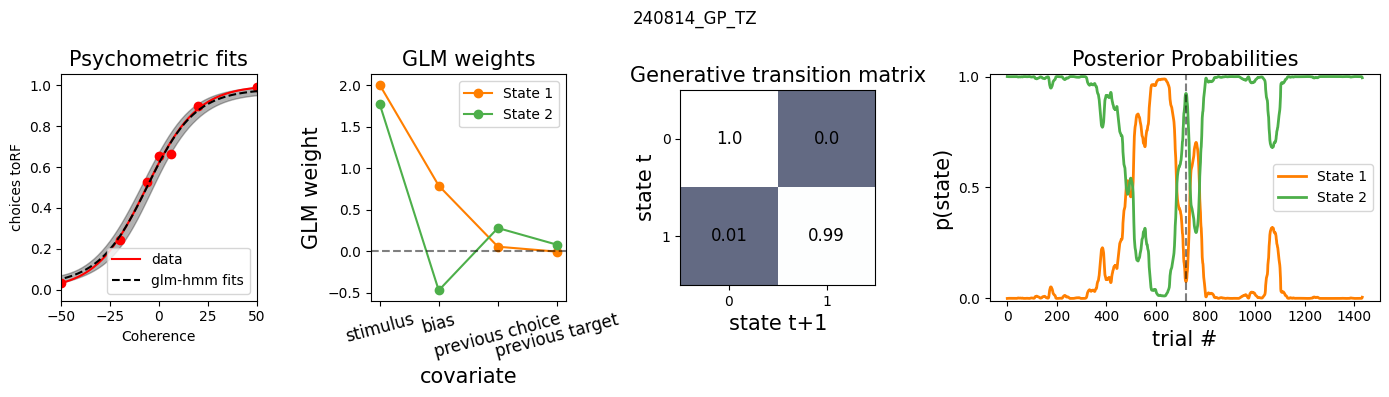

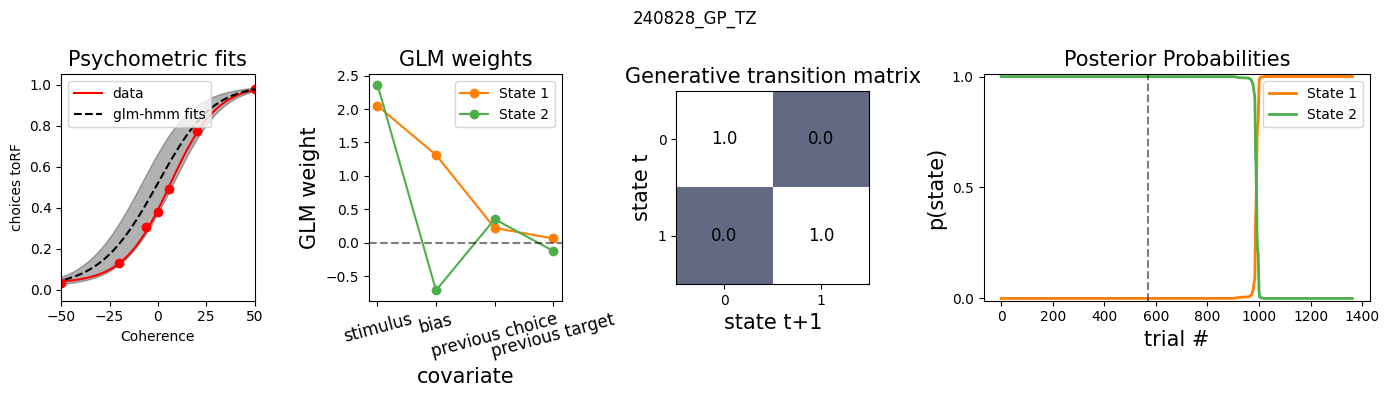

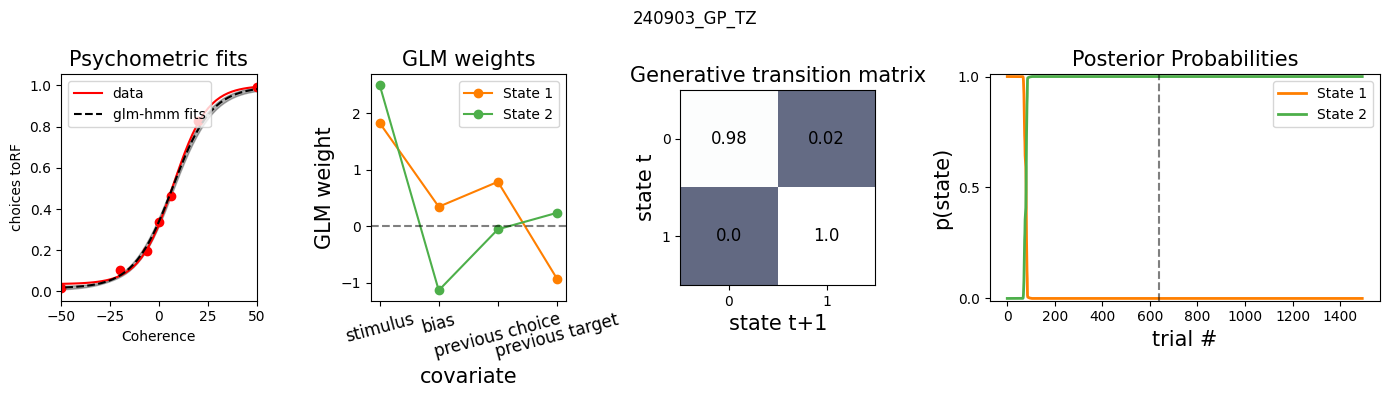

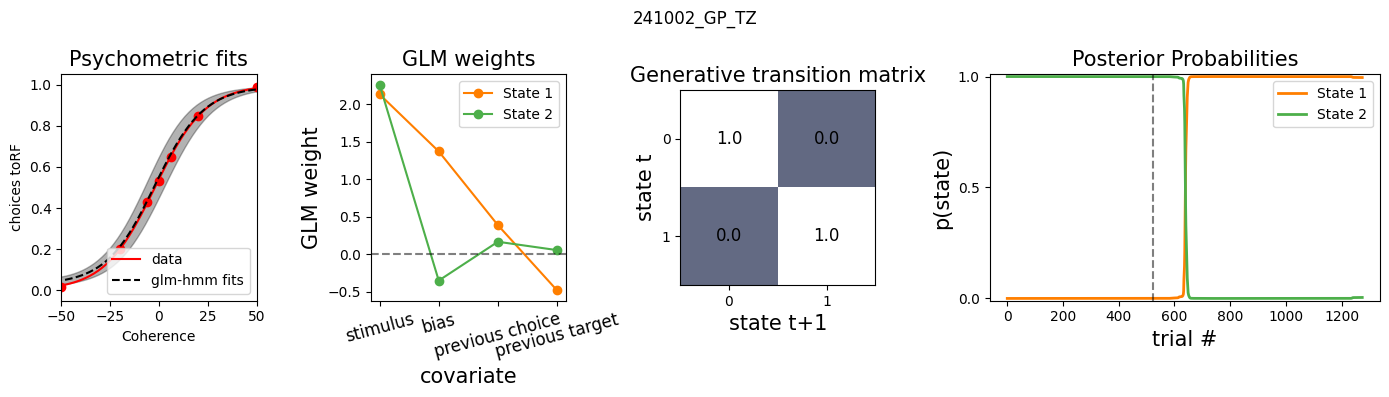

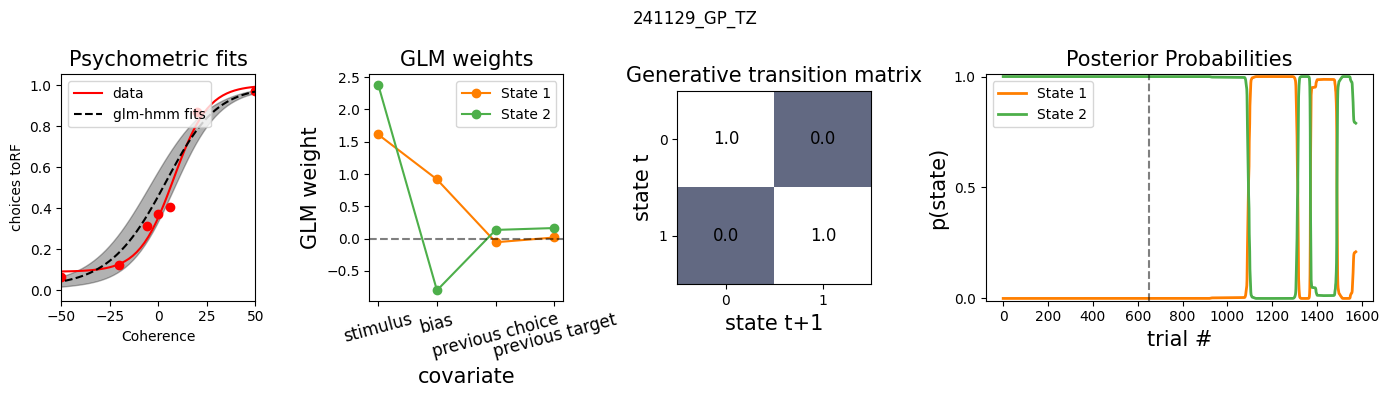

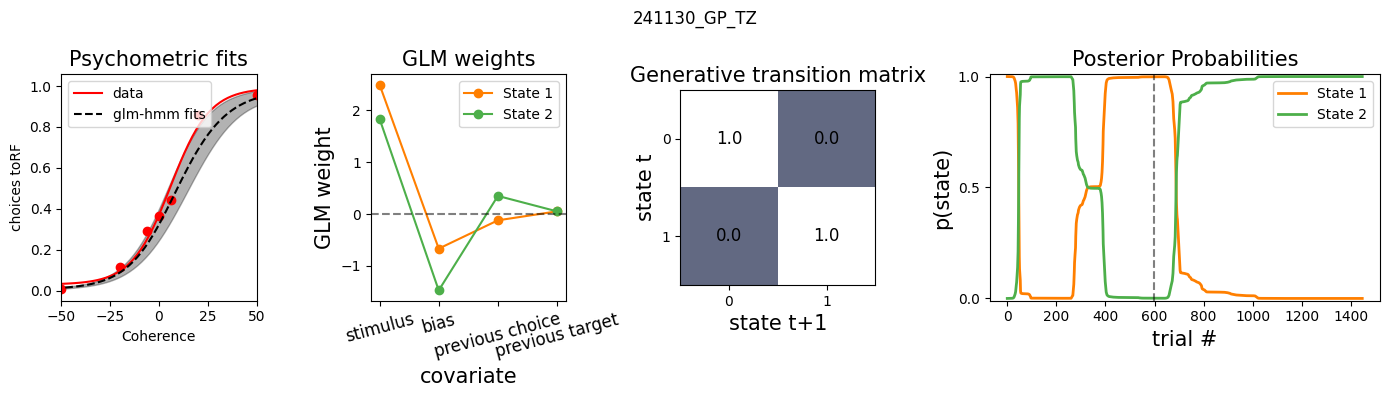

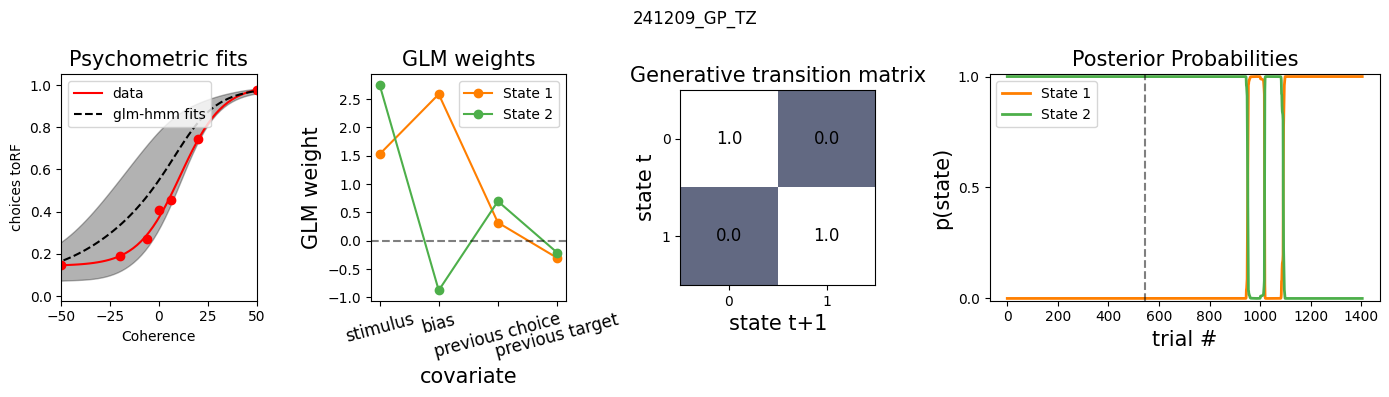

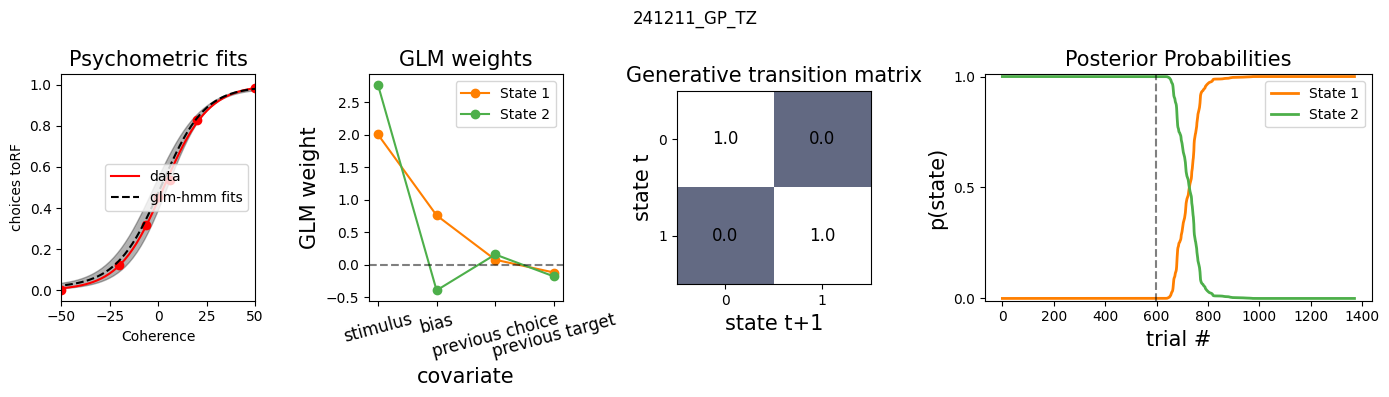

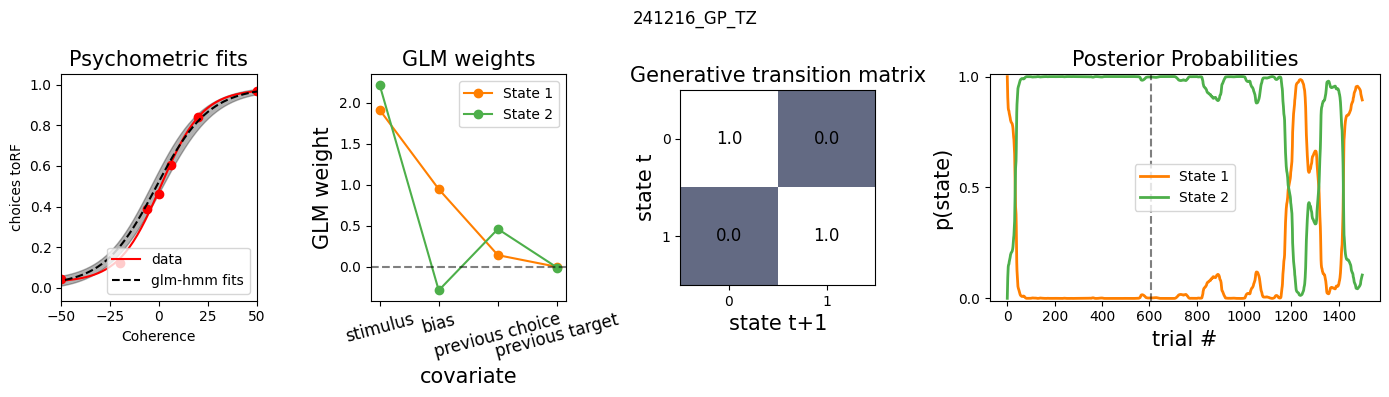

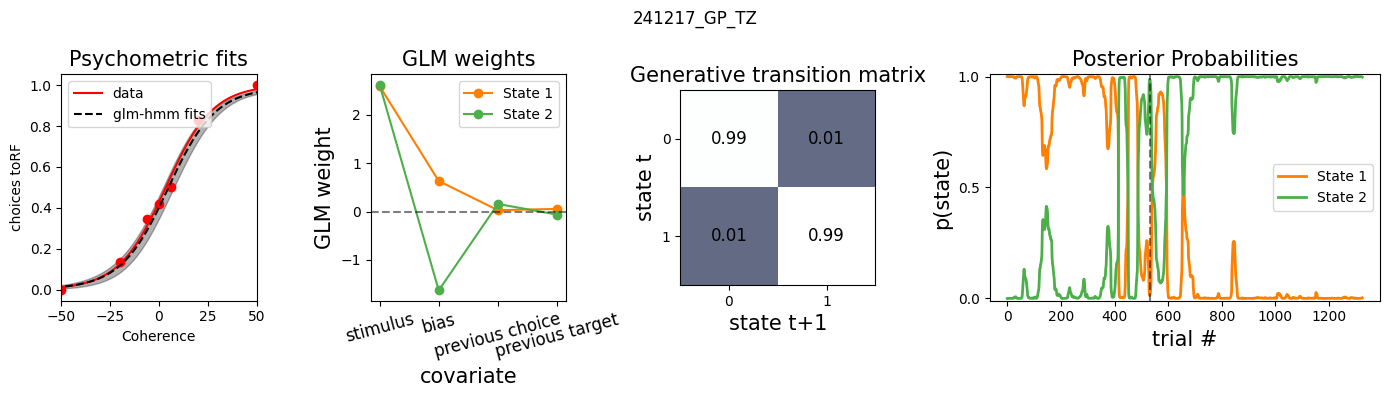

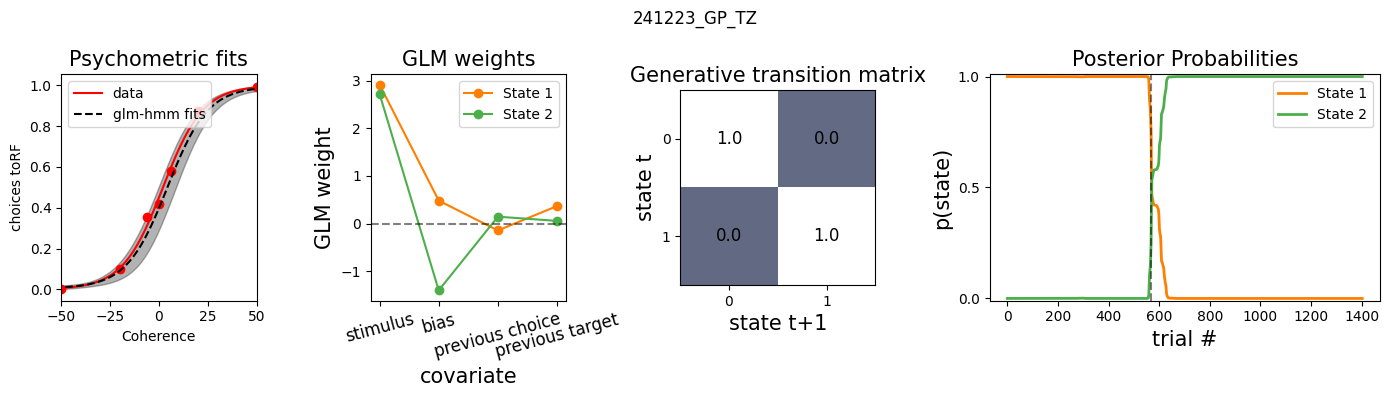

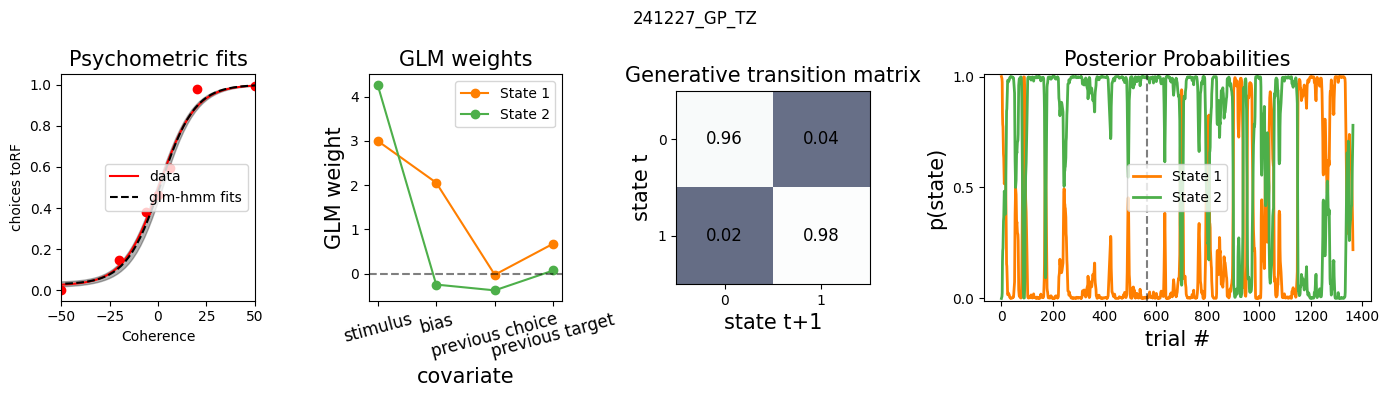

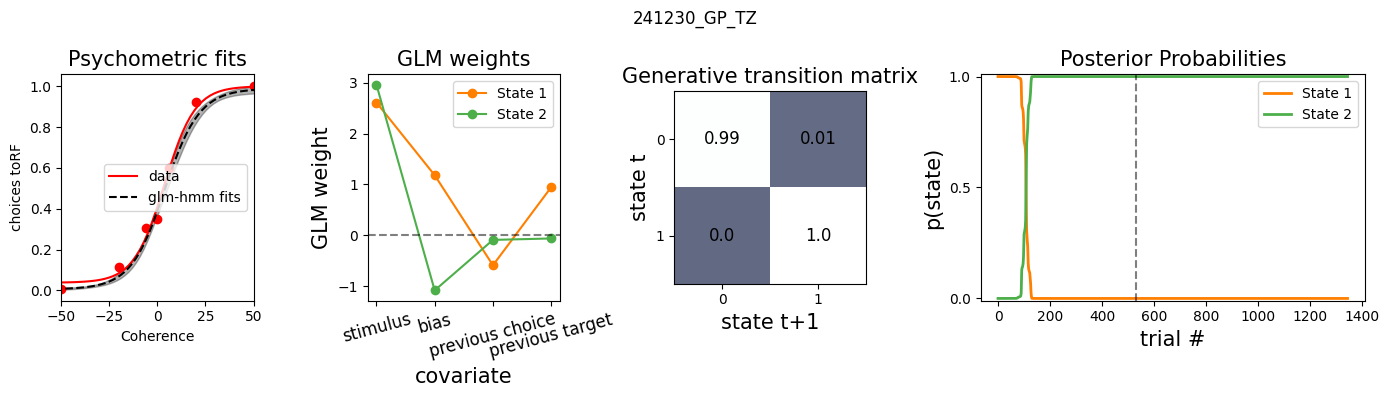

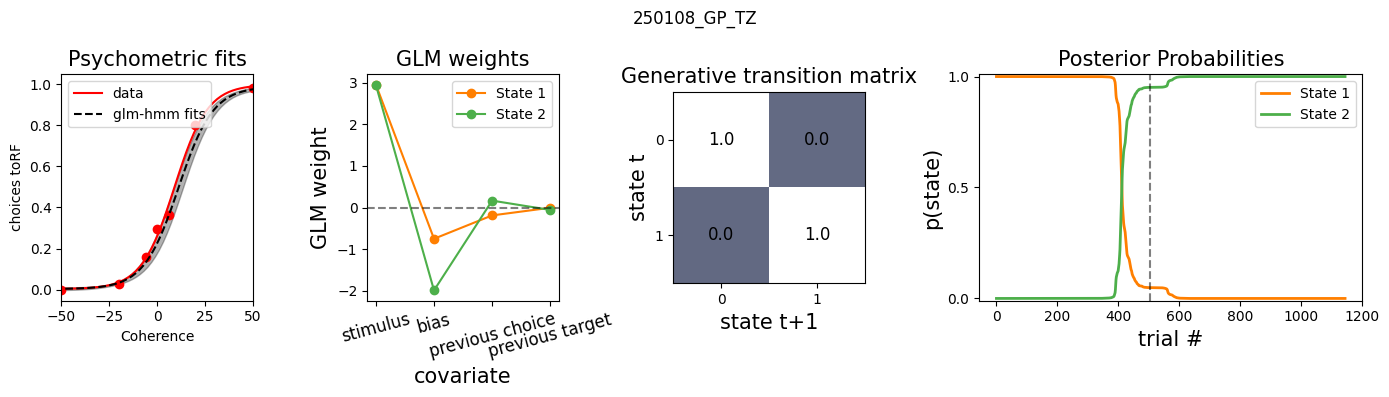

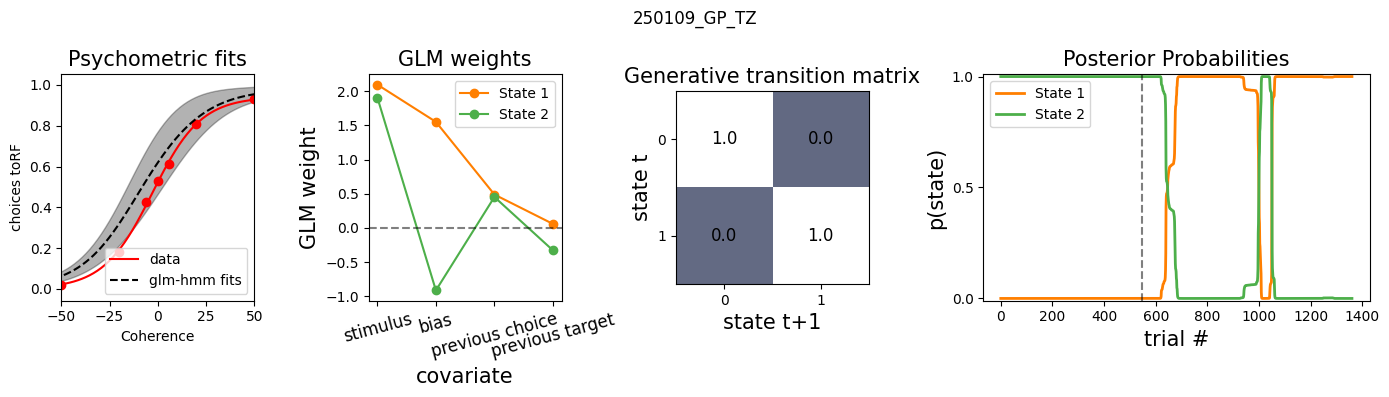

In [155]:
# best_state=1
for session in range(session_wise_fits['test_ll'].shape[0]):
    
    model = session_wise_fits['models'][session][best_state+2][best_fold_session_wise[session]]
    choices = data_session_wise["choices"][session]
    input = data_session_wise["inputs"][session]
    unscaled_input = unnormalized_data_session_wise["inputs"][session]    
    mask = data_session_wise["masks"][session]
    mask = np.ones_like(choices, dtype=bool) if mask is None else mask

    session_name = session_metadata.session_id[session]
    trial_info = pd.read_csv(Path(compiled_dir,session_name,f"{session_name}_trial.csv"))
    trial_info = trial_info[(trial_info.task_type==1) ].reset_index()
    task_switch = np.where((trial_info.prob_toRF != 50) & ~np.isnan(trial_info.prob_toRF))[0][0]
    
    plot_model_fits(model, choices, input, unscaled_input, mask, best_state+2, session_name, task_switch)
    


### data recovery (train and test)

#### unscaled input